# XGBBoost Model

In [77]:
#Libraries
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn import linear_model
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

In [36]:
#Function to evaluate the model
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(ytest, ypred)))

In [65]:
#Data
X_train = pd.read_parquet("../data/processed/X_train.parquet")
y_train = pd.read_parquet("../data/processed/y_train.parquet")['isfraud']
X_test = pd.read_parquet("../data/processed/X_test.parquet")
y_test = pd.read_parquet("../data/processed/y_test.parquet")['isfraud']
X_train_scaled = pd.read_parquet("../data/processed/X_train_scaled.parquet")
X_test_scaled = pd.read_parquet("../data/processed/X_test_scaled.parquet")

In [60]:
#Classifier
classifier = XGBClassifier(n_jobs=-1, random_state=0, use_label_encoder=False)

#Smote
smt = SMOTE(sampling_strategy=0.5, n_jobs=-1)

In [68]:
#Model
clf_xgb = Pipeline(steps=[
    ('smote', smt),
    ('clasificador', classifier)])

In [69]:
clf_xgb.fit(X_train_scaled, y_train)

C:\Users\Alba\anaconda3\envs\practicaEDA\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:13:16] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('smote', SMOTE(n_jobs=-1, sampling_strategy=0.5)),
                ('clasificador',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=-1, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', use_label_encoder=False,
                               validate_parameters=1, verbosity=None))])

In [70]:
y_pred_xgb = clf_xgb.predict(X_test_scaled)
ypred_proba_xgb = clf_xgb.predict_proba(X_test_scaled)

In [72]:
evaluate_model(y_test, y_pred_xgb, ypred_proba_xgb)

ROC-AUC score of the model: 0.9921150531553312
Accuracy of the model: 0.9997138974322295

Classification report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.89      0.84      0.86       228

    accuracy                           1.00    209715
   macro avg       0.95      0.92      0.93    209715
weighted avg       1.00      1.00      1.00    209715


Confusion matrix: 
[[209464     23]
 [    37    191]]



The quality of the model is very good.

The precision refers to the second column of the confusion matrix and its precision is 1 (very high) for cases 0 and 0.89 cases 1 because there are 23 cases that are 0 and it identifies as 1 and 191 cases that are 1 and it does identify as fraud.

The recall refers to the second row of the confusion matrix. It is 1 for 0 cases and 0.84 for 1 cases. The model predicts 37 that should be 1 but predicts them as 0, it hits 191. It predicts minus 1, but misses fewer.

The f1 is one of the best we have obtained so far.

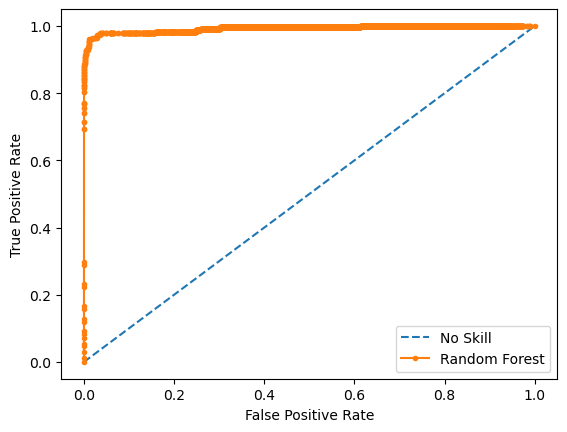

In [81]:
# keep probabilities for the positive outcome only
yhat = ypred_proba_xgb[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Random Forest')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

The ROC curve is not adequate due to the unbalanced data, but it looks like it is almost perfect. In this model it is more reasonable that it be like this because it predicts better.

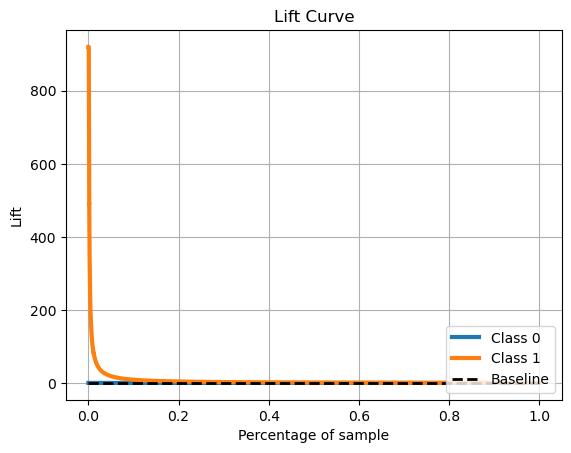

In [80]:
skplt.metrics.plot_lift_curve(y_test, ypred_proba_xgb)
plt.show()

This curve is the best obtained so far.

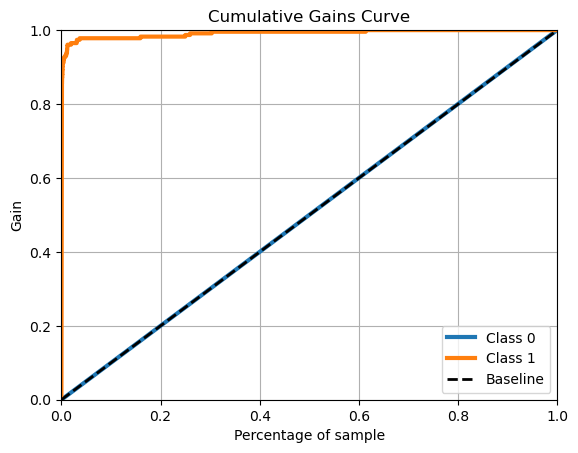

In [73]:
skplt.metrics.plot_cumulative_gain(y_test, ypred_proba_xgb)
plt.show()

Very similar to the ROC curve, it is practically perfect.

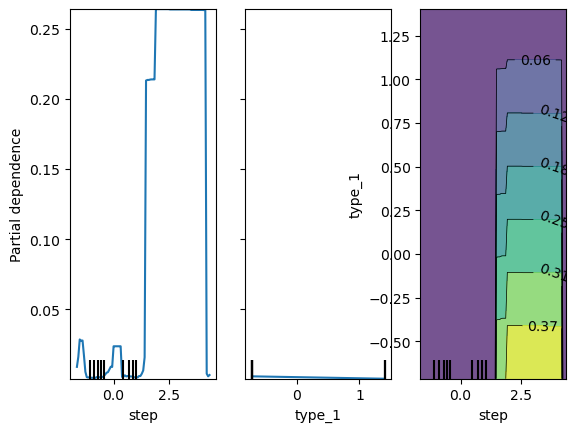

In [79]:
features = [0, 1, (0, 1)]
PartialDependenceDisplay.from_estimator(clf_xgb, X_test_scaled, features)

The coefficients that can be seen in the third graph are higher than in the rest of the models, the variables have more weight and predict better.

In [76]:
with open('../models/XGBBoost.pickle', 'wb') as f:
    pickle.dump(clf_xgb, f)